In [2]:
import pandas as pd 
import numpy as np
from collections import Counter, OrderedDict
import gzip
import os
from multiprocessing import Pool
import subprocess

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

from plotnine import * 

## Analyzing bin counts 

In [3]:
def decide_read_bin(pos, bin_size):
    """
    Decide what bin to use for read with start end. 
    
    """
    
    cbin = int(np.floor(pos / bin_size))
    
    return(cbin)

def decide_read_pair_bin(posA, posB, bin_size):
    """
    Decide what bin to use for read pair. 
    
    """

    binA = decide_read_bin(posA, bin_size)
    binB = decide_read_bin(posB, bin_size)
    
    return([binA, binB])

def chrom_num(x):
    """
    Assign a chromosome number. 
    
    """
    if x not in ['chrX', 'chrY']:
        x = int(x.replace('chr', ''))
        
    elif x == 'chrX':
        x = 23
        
    elif x == 'chrY':
        x = 24
        
    return(x)

def chrom_key(x):
    """
    Generate a chromsome key for sorting. 
    
    """
    
    return(chrom_num(x[0]), chrom_num(x[2]), x[1], x[3])

In [27]:
read_pairs_fn = '/gpfs/data01/glasslab/home/joreyna/projects/CSE283/Project/data/iMARGI_seq/filter200k_final_HEK_iMARGI.pairs'
bin_size = 1000000
all_interactions_fn = read_pairs_fn.replace('pairs', 'bs_{}.pairs'.format(bin_size))

# Excluding non-human chromosomes 
chroms = list(range(1, 23)) + ['X', 'Y']
chroms = ['chr{}'.format(x) for x in chroms]

In [28]:
if not os.path.exists(all_interactions_fn):

    print('Analyzing interactions.')
    
    contact_map = Counter()
    
    with open(read_pairs_fn) as f:
        
        for i, line in enumerate(f):
            
            if line.startswith('#'):
                continue 
                
            line = line.strip()
            vals = line.split()
            chromA, posA, chromB, posB = vals[1:5]
            posA, posB = int(posA), int(posB)

            if chromA in chroms and chromB in chroms: 
                binA, binB = decide_read_pair_bin(posA, posB, bin_size)
                contact_key = (chromA, binA, chromB, binB)
                contact_map[contact_key] += 1 

            if i % 1000000 == 0:
                print(i)
                         
# Write the contact map in sorted order by chromsome and positions 
if not os.path.exists(all_interactions_fn):
    
    print('Writing interactions file.')
    
    # Getting and sorting contact keys 
    contact_keys = contact_map.keys()
    sorted_keys = sorted(contact_keys, key=chrom_key)
    
    # Writing the interactions 
    with open(all_interactions_fn, 'w') as f: 
        for key in sorted_keys: 
            counts = contact_map[key]
            msg = list(key) + [counts]
            msg = '\t'.join([str(x) for x in msg]) + '\n'
            f.write(msg)

Analyzing interactions.
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
Writing interactions file.


## Plotting the heatmap 

In [29]:
def filter_write_contact_data(fn, output_fn, chromA, chromB):
    """
    Filter the data by chromA and chromB and write.
    
    """
    
    if not os.path.exists(output_fn):
        with open(fn) as all_contacts:
            with open(output_fn, 'w') as flt_contacts:
            
                for line in all_contacts: 

                    info = line.strip()
                    chrA, binA, chrB, binB, counts = info.split('\t')    

                    if (chrA == chromA) and (chrB == chromB): 
                        flt_contacts.write(line)

In [30]:
# Writing contact data for chromA and chromB 
chromA, chromB = ('chr9', 'chr9')
ext = '{}_{}.pairs'.format(chromA, chromB)
flt_interactions_fn = all_interactions_fn.replace('pairs', ext) 
if not os.path.exists(flt_interactions_fn):
    filter_write_contact_data(all_interactions_fn, flt_interactions_fn, chromA, chromB)

In [31]:
# Loading the data for chromA and chromB
contact_data = pd.read_table(flt_interactions_fn, names=['chrA', 'binA', 'chrB', 'binB', 'counts'])

# Generating the contact matrix 
max_binA = contact_data.binA.max()
max_binB = contact_data.binB.max()
contact_matrix = np.zeros((max_binA + 1, max_binB + 1))
for (chrA, binA, chrB, binB, count) in contact_data.values:
    contact_matrix[binA, binB] = count

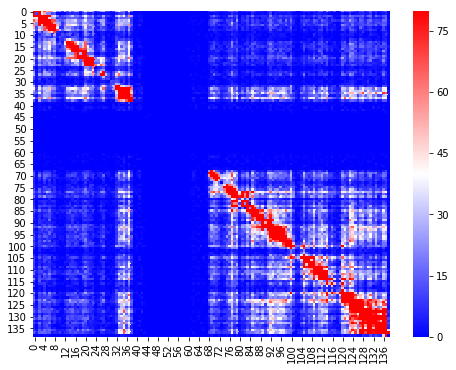

In [32]:
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(contact_matrix+contact_matrix.T , cmap='bwr', vmin=0, vmax=80)

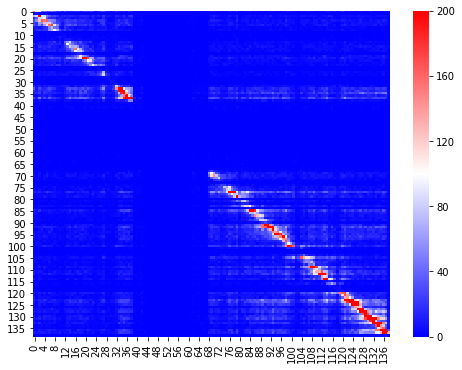

In [33]:
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(contact_matrix, cmap='bwr', vmin=0, vmax=200)